In [48]:
import numpy as np
import math
import nengo
import tensorflow as tf
import keras
import nengo_dl

from matplotlib import pyplot as plt
from urllib.request import urlretrieve
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import confusion_matrix

In [49]:
x, y = load_svmlight_file('Datasets/mnist.scale')
x = x.toarray()
y_train = y.astype(int)

x_train = []
for i in range(x.shape[0]):
    x_train.append(np.append(x[i], [0, 0, 0, 0]))

In [50]:
x, y = load_svmlight_file('Datasets/mnist.scale.t')
x = x.toarray()
y_test = y.astype(int)

x_test = []
for i in range(x.shape[0]):
    x_test.append(np.append([0], x[i]))
    x_test[i] = np.append(x_test[i], [0, 0, 0, 0, 0])

In [51]:
train_images = np.array(x_train)
train_labels = y_train
test_images = np.array(x_test)
test_labels = y_test

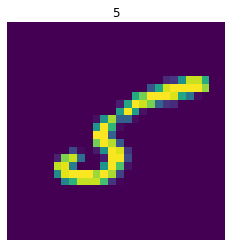

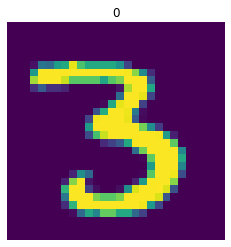

In [52]:
for i in range(2):
    plt.figure()
    plt.imshow(np.reshape(train_images[i+11], (28, 28)))
    plt.axis('off')
    plt.title(str(train_labels[i]));

In [53]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    inp = nengo.Node(np.zeros(28 * 28))
    x = nengo_dl.Layer(tf.keras.layers.Dense(units=100))(inp)
    x = nengo_dl.Layer(neuron_type)(x)

    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [54]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00
Optimization finished in 0:00:00
Construction finished in 0:00:00


In [55]:
# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 50
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In [56]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])


# # note that we use `out_p_filt` when testing (to reduce the spike noise)
# sim.compile(loss={out_p_filt: classification_accuracy})
# print("accuracy before training:", sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"])

In [57]:
# sim.compile(optimizer=tf.optimizers.RMSprop(0.001), loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)})
# sim.fit(train_images, {out_p: train_labels}, epochs=20)

# # save the parameters to file
# sim.save_params("./mnist_params")
sim.load_params("./mnist_params")

In [58]:
import time

start_time = time.time()
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:",
      sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"])
print("Time taken: {}".format(time.time() - start_time))

accuracy after training: 0.9600000011920929
Time taken: 17.749356985092163


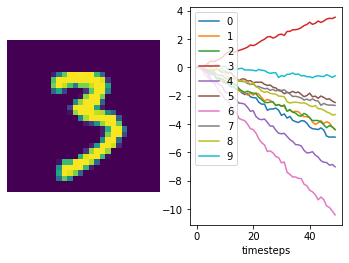

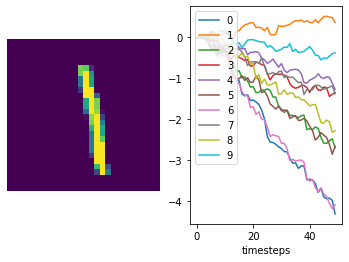

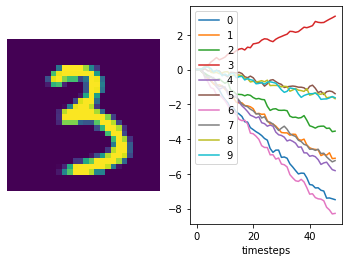

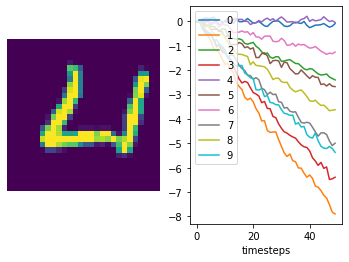

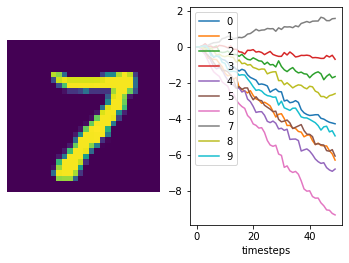

In [59]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i + 30, 0].reshape((28, 28)))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(data[out_p_filt][i+30])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")

In [ ]:
sim.close()